<a href="https://colab.research.google.com/github/E23A48/TF_MachineLearning/blob/main/ML_TF_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXAMEN PARCIAL**
**MACHINE LEARNING**
2020-2



Integrantes:
*   Piero Herrera
*   Camilo Silva
*   Diego Urrutia


## Caso de Estudio – Diagnosticando Retinopatía Diabética


## **Introducción**

El dataset con el que no encontramos es un conjunto de imágenes retinográficas (DR1, DR2). Estos datasets son utilizados con el fin de entrenar modelos de clasificación para reconocer las enfermedades que presentan distintos ojos simplemente con el análisis de una foto. Nuestra motivación es encontrar el mejor modelo que, al ser entrenado con el dataset DR1, presente resultados satisfactorios al clasificar ojos con alguna enfermedad reticular entre las estipuladas. 

Para esta primera parte utilizamos unicamente el dataset DR1 con el fin de hallar el mejor modelo que pueda realizar la clasificación de las imágenes en las 7 clases propuestas dentro del mismo dataset.

Metodología:

1. Descargar dataset de imágenes DR1.
2. Realizar la lectura de la imágenes. (Conversión a numpy.array)
3. Aplicación de *SIFT* y *SURF* para obtener los vectores caracterísitcos de las imágenes del dataset
4. Uso de *Bag of Words* (BoW) con el fin de reducir cada imagen en un vector característico de esta. Se generará dos dataframes como resultado del uso de BoW en los vectores característicos obtenidos en SIFT y SURF
5. Se dividirá la data total en una parte de entrenamiento y test. Para la clasificación se han elegido 5 modelos clasificadores: Gaussian Naive Bayes, Multinomial Naive Bayes, Support Vector Machine, Random Forest y Nearest neighbor
4. Aplicados los modelos se realiza la validación correspondiente y la comparación de resultados obtenidos


### Importación de Librerías

Se realiza una instalación de una versión anterior de opencv, debido a que versiones actuales no permiten realizar el computo de keypoints de SIFT y SURF.

In [1]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 147kB/s 
     |████████████████████████████████| 14.5MB 172kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:


In [6]:
import time
import random
import os as os
import cv2 as cv
import numpy as np
import pandas as pd
import requests, zipfile, io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#Pruebas
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


#Clasificadores
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Pruebas
from sklearn.ensemble import VotingClassifier

#Metricas
from sklearn import metrics
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

### Lectura de la data y asignación de clases

Descarga del dataset del link de origen

In [7]:
url = "https://ndownloader.figshare.com/files/6502308"
local_folder = "/content/dataImages"

# Enviando request para obtener el archivo comprimido con las imagenes
response = requests.get(url)

# Extrayendo archivo comprimido en el entorno local
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(local_folder)

BadZipFile: ignored

Creación de un diccionario para identificar de mejor manera las clases

In [4]:
lesion_types_pre = {'Cotton-wool Spots': 'CS', 'Deep Hemorrhages': 'DH', 'Drusen': 'D', 'Hard Exudates': 'HE', 'Normal Images': 'NI', 'Red Lesions': 'RL', 'Superficial Hemorrhages': 'SH'}

Resize de imágenes

In [5]:
cols = ['img', 'class']
targets = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Nuevas medidas para cada una de las imagenes (Resize)
img_width = 320
img_height = 240

df = pd.DataFrame(columns = cols)

# Recorriendo los directorios de las imagenes y generando el dataframe
for target in lesion_types_pre.keys():
  file_path = "/content/dataImages/DR1-images-by-lesions/"+target
  for image_path in os.listdir(file_path):
     image = cv.imread(file_path + "/" + image_path, cv.IMREAD_COLOR)
     image_resize = cv.resize(image, (img_width, img_height))
     df = df.append({'img': image_resize, 'class': lesion_types_pre[target]}, ignore_index=True)

df.groupby('class').count()

NameError: ignored

Podemos apreciar la cantidad de imágenes que hay por clase

**Muestra Previa de imagenes y respectiva clase**

<Figure size 432x288 with 0 Axes>

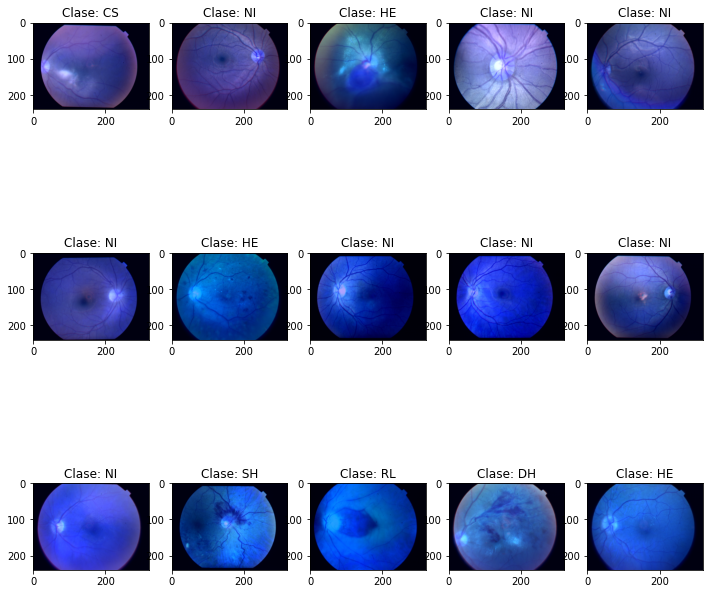

In [6]:
plt.figure()

f, axarr = plt.subplots(3,5, figsize=(12,12)) 

for i in range(0, 3):
  for j in range(0, 5):
    item_index =random.randint(0,df.shape[0])
    axarr[i][j].imshow(df.iloc[item_index]['img'])
    axarr[i][j].set_title("Clase: " + df.iloc[item_index]['class'])
plt.show()

#### Aplicación de SIFT

Sift es un algoritmo que permite detectar y describir características locales en imágenes. Para ello se sigue una serie de pasos:
1. **Selección de picos de espacio de escala**: ubicación potencial para encontrar 
entidades.
2. **Localización de puntos clave** : localización precisa de los puntos clave de funciones.
3. **Asignación de orientación**: asignación de orientación a puntos clave.
4. **Descriptor de puntos clave** : describe los puntos clave como un vector.
5. **Coincidencia de puntos clave**

Dimensiones:  (71, 128)


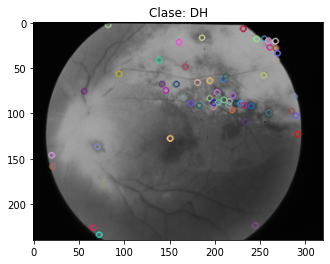

In [7]:
sift = cv.xfeatures2d.SIFT_create()

# Funcion para extraer keypoints con SIFT dado una imagen
def extractKeypointsSift(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  sift_kp, sift_des = sift.detectAndCompute(gray,None)
  return sift_kp, sift_des

random_index = random.randint(0,df.shape[0])
sift_test_img = df.iloc[random_index]['img']
sift_test_class = df.iloc[random_index]['class']

sift_test_keypoints, sift_test_descriptor = extractKeypointsSift(sift_test_img)

gray = cv.cvtColor(sift_test_img, cv.COLOR_BGR2GRAY)
img_sift_kp = cv.drawKeypoints(gray, sift_test_keypoints, None)

print("Dimensiones: ", sift_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+sift_test_class)
plt.imshow(img_sift_kp)
plt.show()

##### Extracción de Keypoints SIFT

In [8]:
start_time_sift = time.time()

# Vectores que almacenan los keypoints y sus descriptores
fSift = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores
for i, row in df.iterrows():
  sift_img = extractKeypointsSift(row['img'])
  fSift.append(sift_img)

print("Keypoints SIFT extraidos en %s segundos"  % (time.time() - start_time_sift))

Keypoints SIFT extraidos en 37.51695704460144 segundos


#### Aplicación de SURF

SURF es un algoritmo para la representación y la comparación local de imágenes. De manera similar a otros métetodos también basados en descriptores locales, los *keyponits* de una imagen dada se definen como características sobresalientes de una representación invariante de escala. Dicho análisis se obtiene mediante la convolución de la imagen inicial con granos discretos a varias escalas (filtros de caja) seguido del uso de gradientes locales (intensidad y orientación).

Dimensiones:  (265, 64)


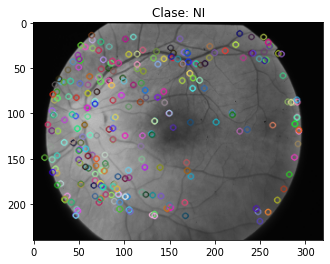

In [9]:
surf = cv.xfeatures2d.SURF_create()

# Funcion para extraer keypoints con SURF dado una imagen
def extractKeypointsSurf(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  surf_kp, surf_des = surf.detectAndCompute(gray,None)
  return surf_kp, surf_des

random_index = random.randint(0,df.shape[0])
surf_test_img = df.iloc[random_index]['img']
surf_test_class = df.iloc[random_index]['class']

surf_test_keypoints, surf_test_descriptor = extractKeypointsSurf(surf_test_img)

gray = cv.cvtColor(surf_test_img, cv.COLOR_BGR2GRAY)
img_surf_kp = cv.drawKeypoints(gray, surf_test_keypoints, None)

print("Dimensiones: ", surf_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+surf_test_class)
plt.imshow(img_surf_kp)
plt.show()

##### Extracción de Keypoints SURF

In [10]:
start_time_surf = time.time()
# Vectores que almacenan los keypoints y sus descriptores
fSurf = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores 
for i, row in df.iterrows():
  surf_img = extractKeypointsSurf(row['img'])
  fSurf.append(surf_img)

print("Keypoints SURF extraidos en %s segundos"  % (time.time() - start_time_surf))



Keypoints SURF extraidos en 53.84445881843567 segundos


#### Aplicación de ORB


Dimensiones:  (159, 32)


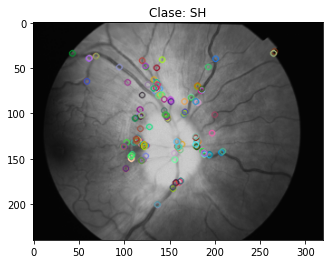

In [11]:
orb = cv.ORB_create()


# Funcion para extraer keypoints con SIFT dado una imagen
def extractKeypointsOrb(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  orb_kp, orb_des = orb.detectAndCompute(gray,None)
  return orb_kp, orb_des

random_index = random.randint(0,df.shape[0])
orb_test_img = df.iloc[random_index]['img']
orb_test_class = df.iloc[random_index]['class']

orb_test_keypoints, orb_test_descriptor = extractKeypointsOrb(orb_test_img)

gray = cv.cvtColor(orb_test_img, cv.COLOR_BGR2GRAY)
img_orb_kp = cv.drawKeypoints(gray, orb_test_keypoints, None)

print("Dimensiones: ", orb_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+orb_test_class)
plt.imshow(img_orb_kp)
plt.show()

##### Extracción de Keypoints ORB

In [12]:
start_time_orb = time.time()

# Vectores que almacenan los keypoints y sus descriptores
fOrb = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores
for i, row in df.iterrows():
  orb_img = extractKeypointsOrb(row['img'])
  fOrb.append(orb_img)

print("Keypoints Orb extraidos en %s segundos"  % (time.time() - start_time_orb))



Keypoints Orb extraidos en 4.176119804382324 segundos


### Bag of Words

Modelo para simplificar caraterísticas obtenidas

In [13]:
from sklearn.cluster import MiniBatchKMeans

def applyBow(fFile, df):

  start_time = time.time()

  # Vector que contendrá cada uno de los descriptores
  data = []

  # Recorremos toda la lista de keypoints
  for kp, kp_des in fFile:
    # Recorremos los descriptores de cada imagen
    for kpd in kp_des:
      # Los agregamos al vector
      data.append(kpd)

  # Inicializamos nuestro kmeans, con 50 clusters
  # y un batch size de 6000, y lo entrenamos para agrupar los descriptores
  kmeans = MiniBatchKMeans(n_clusters=20, verbose=0).fit(data)

  kmeans.verbose = False

  # Inicializando un vector que contendrá vectores
  # con cada uno de los histogramas de las imagenes
  features_hist = []
  for kp, kp_des in fFile:
    # Inicializando el histograma que cuantifica las ocurrencias
    # de cada uno de los clusters (50) en cada una de las imagenes
    hist = np.zeros(20)
    for kpd in kp_des:
      # Prediciendo el grupo al que pertenece
      # cada uno de los keypoints
      feature = kmeans.predict([kpd])
      hist[feature] += 1
    # Agregando el histograma de la imagen al
    # vector de histogramas
    features_hist.append(hist)
  
  print("BoW generado en %s segundos"  % (time.time() - start_time))

  # Agregando la clase a cada uno de los 
  # vectores de histograma
  for i, row in df.iterrows():
    features_hist[i] = np.append(features_hist[i], row['class'])

  # Generando un dataframe con los histogramas
  # y la clase de cada imagen como target
  cols = [ 'X'+str(i) for i in range(20) ]
  cols.append('class')

  df_bow = pd.DataFrame(data=features_hist, columns=cols)
  
  return df_bow


### Data Sets de Características resultantes

##### SURF

In [14]:
df_surf= applyBow(fSurf, df)

BoW generado en 131.11794686317444 segundos


In [15]:
df_surf.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,39.0,4.0,11.0,4.0,42.0,3.0,8.0,16.0,8.0,1.0,0.0,7.0,10.0,7.0,16.0,7.0,7.0,11.0,5.0,18.0,CS
1,8.0,1.0,4.0,2.0,52.0,3.0,4.0,9.0,2.0,3.0,4.0,1.0,7.0,6.0,3.0,2.0,5.0,4.0,4.0,4.0,CS
2,13.0,7.0,8.0,9.0,26.0,8.0,14.0,16.0,8.0,7.0,0.0,4.0,5.0,15.0,13.0,15.0,6.0,12.0,5.0,9.0,CS
3,3.0,0.0,3.0,3.0,25.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,4.0,5.0,3.0,3.0,0.0,1.0,3.0,2.0,CS
4,27.0,0.0,10.0,11.0,43.0,7.0,12.0,11.0,4.0,10.0,1.0,13.0,11.0,12.0,12.0,4.0,10.0,6.0,12.0,15.0,CS


In [16]:
df_surf.shape

(1469, 21)

##### SIFT

In [17]:
df_sift = applyBow(fSift,df)

BoW generado en 60.36780261993408 segundos


In [18]:
df_sift.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,4.0,0.0,3.0,11.0,6.0,7.0,5.0,6.0,23.0,2.0,6.0,4.0,3.0,3.0,2.0,3.0,6.0,8.0,5.0,7.0,CS
1,1.0,0.0,3.0,31.0,0.0,1.0,0.0,6.0,2.0,2.0,0.0,0.0,1.0,2.0,0.0,6.0,2.0,0.0,0.0,0.0,CS
2,5.0,2.0,4.0,13.0,9.0,5.0,4.0,3.0,12.0,4.0,6.0,4.0,1.0,4.0,1.0,4.0,7.0,2.0,3.0,9.0,CS
3,2.0,0.0,5.0,3.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,4.0,2.0,0.0,0.0,0.0,CS
4,8.0,0.0,4.0,31.0,9.0,8.0,6.0,8.0,6.0,8.0,10.0,3.0,1.0,3.0,10.0,7.0,10.0,14.0,8.0,16.0,CS


In [19]:
df_sift.shape

(1469, 21)

ORB

In [20]:
df_orb = applyBow(fOrb,df)

BoW generado en 82.48435711860657 segundos


In [21]:
df_orb.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,6.0,15.0,4.0,10.0,8.0,10.0,1.0,4.0,5.0,11.0,1.0,3.0,19.0,0.0,8.0,12.0,8.0,6.0,6.0,5.0,CS
1,7.0,4.0,1.0,4.0,2.0,7.0,5.0,0.0,0.0,3.0,1.0,2.0,7.0,3.0,2.0,0.0,1.0,1.0,3.0,3.0,CS
2,12.0,10.0,4.0,0.0,8.0,19.0,6.0,1.0,11.0,8.0,5.0,1.0,9.0,4.0,8.0,0.0,3.0,5.0,6.0,5.0,CS
3,2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,CS
4,27.0,35.0,8.0,15.0,11.0,32.0,14.0,8.0,12.0,7.0,17.0,11.0,32.0,9.0,12.0,14.0,8.0,9.0,12.0,17.0,CS


In [22]:
df_orb.shape

(1469, 21)

### Dataset de Entrenamieto y Test

Para las pruebas individuales realizamos la división del data frame total. Un 40% de la data sirvió para el entrenamiento y el 60% se usó como test.

Surf

In [23]:
X_Surf = df_surf[[x for x in df_surf.columns if x != 'class']]
y_Surf = df_surf['class']

scaler = QuantileTransformer()
X_Surf = pd.DataFrame(scaler.fit_transform(X_Surf), columns=X_Surf.columns)
X_train_Surf, X_test_Surf, y_train_Surf, y_test_Surf = train_test_split(X_Surf, y_Surf, random_state = 10,shuffle=True,test_size = 0.4)

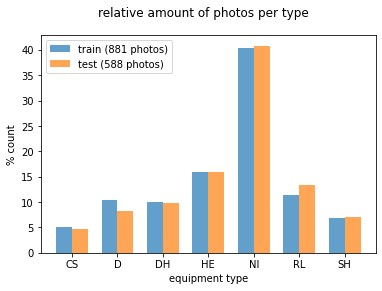

In [24]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train_Surf, loc='left')
plot_bar(y_test_Surf, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train_Surf)),
    'test ({0} photos)'.format(len(y_test_Surf))
]);

Sift

In [25]:
X_Sift = df_sift[[x for x in df_sift.columns if x != 'class']]
y_Sift = df_sift['class']

scaler = QuantileTransformer()
print(scaler)
X_Sift = pd.DataFrame(scaler.fit_transform(X_Sift), columns=X_Sift.columns)

X_train_Sift, X_test_Sift, y_train_Sift, y_test_Sift = train_test_split(X_Sift, y_Sift, random_state = 42,shuffle=True,test_size = 0.2)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)


Orb

In [26]:
X_Orb = df_orb [[x for x in df_orb.columns if x != 'class']]
y_Orb = df_orb['class']

scaler = QuantileTransformer()
X_Orb = pd.DataFrame(scaler.fit_transform(X_Orb), columns = X_Orb.columns)

X_train_Orb, X_test_Orb, y_train_Orb, y_test_Orb = train_test_split(X_Orb, y_Orb, random_state = 10,shuffle=True, test_size = 0.2)

**KFold**

En este caso usamos un numero de divisiones igual a 15 y activamos el parametro random_state para que estas divisiones sean aleatorias.

In [27]:
kfold = KFold(n_splits = 15, random_state = 10, shuffle= True)

### Modelos de Clasificación

Como mencionamos anteriormente, se eligieron 5 modelos de clasificación con el fin de encontrar el que nos devolvía mejores resultado en relación al **accuracy**

In [28]:
#@title ##### Función plot Matriz Gráfica
def showconfusionamtrix(cm):
  plt.matshow(cm)
  plt.colorbar()
  plt.show()

#### **Support Vector Machine (SVM)**

Es un modelo de **aprendizaje supervisado** que analizan los datos utilizados para realizar tanto clasificaciones como regresiones.

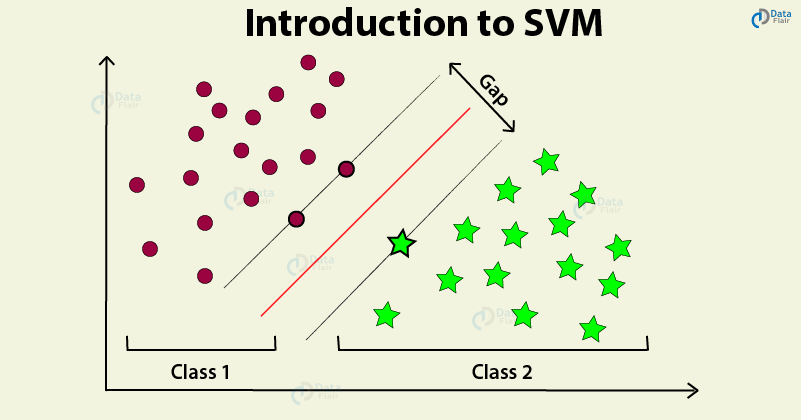

##### SURF

              precision    recall  f1-score   support

          CS       1.00      0.11      0.19        28
           D       0.44      0.15      0.22        48
          DH       0.00      0.00      0.00        58
          HE       0.31      0.34      0.33        94
          NI       0.58      0.97      0.73       240
          RL       0.15      0.06      0.09        79
          SH       0.07      0.02      0.04        41

    accuracy                           0.48       588
   macro avg       0.36      0.24      0.23       588
weighted avg       0.40      0.48      0.39       588

Accuracy Calculado: 0.47959183673469385
F1 Calculado 0.39042117482552613
Accuracy CrossValidation: 0.47445122378848453 

MATRIZ DE CONFUSIÓN



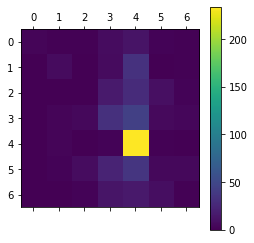

,0,1,2,3,4,5,6
0,3,1,1,8,12,2,1
1,0,7,0,7,33,0,1
2,0,0,0,17,29,10,2
3,0,3,5,32,44,6,4
4,0,3,0,2,234,1,0
5,0,2,8,23,36,5,5
6,0,0,2,13,16,9,1


In [29]:
SVM_Surf = svm.SVC(kernel='rbf') 

SVM_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_SVM = SVM_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_SVM,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_SVM))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_SVM,average= 'weighted'))
print("Accuracy CrossValidation:", cross_val_score(SVM_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_SVM = confusion_matrix(y_test_Surf,y_pred_Surf_SVM)
DF_CM_SURF_SVM = pd.DataFrame(data = CM_SURF_SVM)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_SVM)
DF_CM_SURF_SVM


##### SIFT

              precision    recall  f1-score   support

          CS       0.00      0.00      0.00        16
           D       0.50      0.12      0.20        33
          DH       0.00      0.00      0.00        21
          HE       0.37      0.40      0.38        55
          NI       0.56      0.97      0.71       109
          RL       0.03      0.03      0.03        36
          SH       0.00      0.00      0.00        24

    accuracy                           0.45       294
   macro avg       0.21      0.22      0.19       294
weighted avg       0.34      0.45      0.36       294

Accuracy Calculado: 0.4523809523809524
Accuracy CrossValidation: 0.46764850270004915 

MATRIZ DE CONFUSIÓN



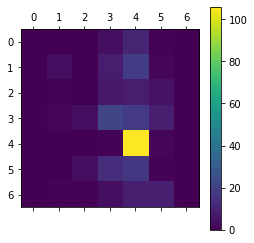

,0,1,2,3,4,5,6
0,0,0,0,4,11,1,0
1,0,4,0,8,19,2,0
2,0,1,0,7,8,5,0
3,0,2,4,22,18,9,0
4,0,0,0,1,106,2,0
5,0,0,4,14,17,1,0
6,0,1,1,4,9,9,0


In [30]:
SVM_Sift = svm.SVC(kernel='rbf') 

SVM_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_SVM = SVM_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_SVM,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_SVM = confusion_matrix(y_test_Sift,y_pred_Sift_SVM)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_SVM)
DF_CM_SIFT_SVM = pd.DataFrame(data = CM_SIFT_SVM)
DF_CM_SIFT_SVM

ORB

              precision    recall  f1-score   support

          CS       0.00      0.00      0.00        15
           D       0.50      0.03      0.06        29
          DH       0.00      0.00      0.00        33
          HE       0.29      0.39      0.33        49
          NI       0.50      0.94      0.65       115
          RL       0.10      0.03      0.05        33
          SH       0.00      0.00      0.00        20

    accuracy                           0.44       294
   macro avg       0.20      0.20      0.16       294
weighted avg       0.31      0.44      0.32       294

Accuracy Calculado: 0.4387755102040816
Accuracy CrossValidation: 0.44860789676695423 

MATRIZ DE CONFUSIÓN



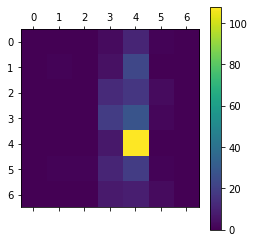

,0,1,2,3,4,5,6
0,0,0,0,3,11,1,0
1,0,1,0,5,23,0,0
2,0,0,0,13,17,3,0
3,0,0,0,19,28,2,0
4,0,0,0,7,108,0,0
5,0,1,1,11,19,1,0
6,0,0,0,8,9,3,0


In [31]:
SVM_Orb = svm.SVC(kernel = 'rbf')

SVM_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_SVM = SVM_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_SVM, zero_division = 0))

print("Accuracy Calculado:", metrics.accuracy_score(y_test_Orb, y_pred_Orb_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Orb, X_Orb, y_Orb, cv = kfold, scoring = "accuracy").mean(), "\n")

CM_ORB_SVM = confusion_matrix(y_test_Orb, y_pred_Orb_SVM)
DF_CM_ORB_SVM = pd.DataFrame(data = CM_ORB_SVM)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_SVM)
DF_CM_ORB_SVM

#### **Random Forest** 

Es un algoritmo de clasificación que está basado en árboles de decisiones. Construye de manera aleatoria cada árbol individual para tratar de crear un bosque de árboles no correlacionado cuya predicción es más precisa que la de cualquier árbol individual. 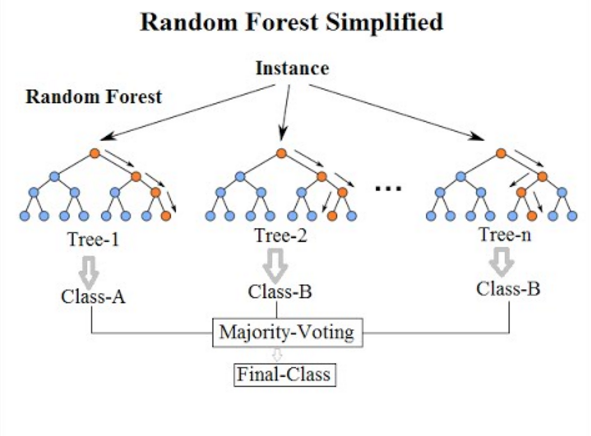

##### SURF

              precision    recall  f1-score   support

          CS       0.00      0.00      0.00        28
           D       0.00      0.00      0.00        48
          DH       0.00      0.00      0.00        58
          HE       0.24      0.19      0.21        94
          NI       0.47      1.00      0.64       240
          RL       0.00      0.00      0.00        79
          SH       0.00      0.00      0.00        41

    accuracy                           0.44       588
   macro avg       0.10      0.17      0.12       588
weighted avg       0.23      0.44      0.29       588

Accuracy Calculado: 0.4387755102040816
Accuracy CrossValidation: 0.4390911003576689 

MATRIZ DE CONFUSIÓN



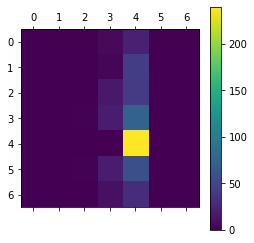

,0,1,2,3,4,5,6
0,0,0,0,6,22,0,0
1,0,0,0,4,44,0,0
2,0,0,0,16,42,0,0
3,0,0,1,18,75,0,0
4,0,0,0,0,240,0,0
5,0,0,1,19,59,0,0
6,0,0,0,11,30,0,0


In [32]:
RF_Surf = RandomForestClassifier(max_depth=3, random_state=10)
RF_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_RF = RF_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_RF = confusion_matrix(y_test_Surf,y_pred_Surf_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_RF)
DF_CM_SURF_RF = pd.DataFrame(data = CM_SURF_RF)
DF_CM_SURF_RF

##### SIFT

              precision    recall  f1-score   support

          CS       0.00      0.00      0.00        16
           D       0.33      0.03      0.06        33
          DH       0.00      0.00      0.00        21
          HE       0.31      0.29      0.30        55
          NI       0.46      0.99      0.63       109
          RL       0.14      0.03      0.05        36
          SH       0.00      0.00      0.00        24

    accuracy                           0.43       294
   macro avg       0.18      0.19      0.15       294
weighted avg       0.29      0.43      0.30       294

Accuracy Calculado: 0.42857142857142855
Accuracy CrossValidation: 0.44113191668419954 

MATRIZ DE CONFUSIÓN



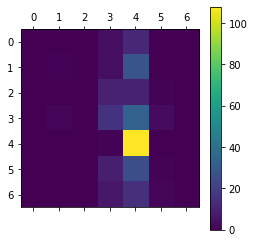

,0,1,2,3,4,5,6
0,0,0,0,4,12,0,0
1,0,1,0,4,28,0,0
2,0,0,0,10,10,1,0
3,0,2,0,16,34,3,0
4,0,0,0,1,108,0,0
5,0,0,0,9,26,1,0
6,0,0,0,7,15,2,0


In [33]:
RF_Sift = RandomForestClassifier(max_depth=3, random_state=10)
RF_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_RF = RF_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_RF = confusion_matrix(y_test_Sift,y_pred_Sift_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_RF)
DF_CM_SIFT_RF = pd.DataFrame(data = CM_SIFT_RF)
DF_CM_SIFT_RF

#### **KNeighborsClassifier**

El principio detrás este modelo es encontrar un número predefinido de muestras de entrenamiento más cercanas en distancia al nuevo punto y de esta forma la la clase a partir de ellas. El valor de ***n*** nos indica la cantidad de vecinos que tomaremos en cuenta para la clasificación y la complejidad. 

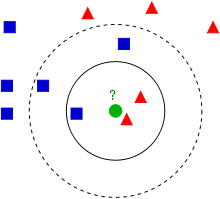

##### SURF

              precision    recall  f1-score   support

          CS       0.17      0.04      0.06        28
           D       0.24      0.15      0.18        48
          DH       0.14      0.10      0.12        58
          HE       0.22      0.17      0.19        94
          NI       0.56      0.91      0.70       240
          RL       0.17      0.09      0.12        79
          SH       0.12      0.02      0.04        41

    accuracy                           0.44       588
   macro avg       0.23      0.21      0.20       588
weighted avg       0.34      0.44      0.36       588

Accuracy Calculado: 0.4370748299319728
Accuracy CrossValidation: 0.44317273301073007 

MATRIZ DE CONFUSIÓN



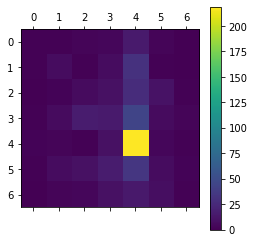

,0,1,2,3,4,5,6
0,1,1,3,4,16,3,0
1,1,7,1,7,31,1,0
2,0,2,6,10,28,11,1
3,1,6,17,16,45,6,3
4,2,3,1,10,219,4,1
5,1,7,10,17,35,7,2
6,0,3,4,10,15,8,1


In [34]:
KNN_Surf = KNeighborsClassifier(n_neighbors=15)

KNN_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_KNN = KNN_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_KNN = confusion_matrix(y_test_Surf,y_pred_Surf_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_KNN)
DF_CM_SURF_KNN = pd.DataFrame(data = CM_SURF_KNN)
DF_CM_SURF_KNN

##### SIFT

              precision    recall  f1-score   support

          CS       0.38      0.19      0.25        16
           D       0.28      0.15      0.20        33
          DH       0.00      0.00      0.00        21
          HE       0.28      0.24      0.25        55
          NI       0.55      0.94      0.69       109
          RL       0.11      0.06      0.07        36
          SH       0.00      0.00      0.00        24

    accuracy                           0.43       294
   macro avg       0.23      0.22      0.21       294
weighted avg       0.32      0.43      0.35       294

Accuracy Calculado: 0.42517006802721086
Accuracy CrossValidation: 0.4384318675923978 

MATRIZ DE CONFUSIÓN



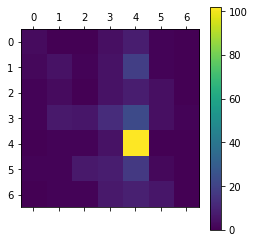

,0,1,2,3,4,5,6
0,3,0,0,4,8,1,0
1,2,5,1,5,19,1,0
2,1,3,0,5,8,4,0
3,1,7,6,13,23,4,1
4,0,1,1,5,102,0,0
5,1,1,7,8,17,2,0
6,0,1,1,7,9,6,0


In [35]:
KNN_Sift = KNeighborsClassifier(n_neighbors=15)

KNN_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_KNN = KNN_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_KNN = confusion_matrix(y_test_Sift,y_pred_Sift_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_KNN)
DF_CM_SIFT_KNN = pd.DataFrame(data = CM_SIFT_KNN)
DF_CM_SIFT_KNN

#### **Multinomial Naive Bayes**

Modelo que mejora el desempeño del Naive Bayes simple. Este modelo considera el número de apariciones del término para evaluar la contribución de la probabilidad condicional dada la clase con lo que el modelado de cada documento se ajusta mejor a la clase a la que pertenece.

##### SURF

              precision    recall  f1-score   support

          CS       0.00      0.00      0.00        28
           D       0.00      0.00      0.00        48
          DH       0.00      0.00      0.00        58
          HE       0.25      0.05      0.09        94
          NI       0.42      1.00      0.59       240
          RL       0.00      0.00      0.00        79
          SH       0.00      0.00      0.00        41

    accuracy                           0.42       588
   macro avg       0.10      0.15      0.10       588
weighted avg       0.21      0.42      0.26       588

Accuracy Calculado: 0.4166666666666667
Accuracy CrossValidation: 0.41255347499824674 

MATRIZ DE CONFUSIÓN



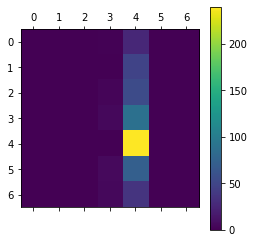

,0,1,2,3,4,5,6
0,0,0,0,1,27,0,0
1,0,0,0,0,48,0,0
2,0,0,0,3,55,0,0
3,0,0,0,5,89,0,0
4,0,0,0,0,240,0,0
5,0,0,0,6,73,0,0
6,0,0,0,5,36,0,0


In [36]:
MNB_Surf = MultinomialNB(alpha=1)

MNB_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_MNB = MNB_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_MNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_MNB))
print("Accuracy CrossValidation:", cross_val_score(MNB_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_MNB = confusion_matrix(y_test_Surf,y_pred_Surf_MNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_MNB)
DF_CM_SURF_MNB = pd.DataFrame(data = CM_SURF_MNB)
DF_CM_SURF_MNB

##### SIFT

              precision    recall  f1-score   support

          CS       0.00      0.00      0.00        16
           D       0.00      0.00      0.00        33
          DH       0.00      0.00      0.00        21
          HE       0.39      0.20      0.27        55
          NI       0.42      1.00      0.59       109
          RL       0.00      0.00      0.00        36
          SH       0.00      0.00      0.00        24

    accuracy                           0.41       294
   macro avg       0.12      0.17      0.12       294
weighted avg       0.23      0.41      0.27       294

Accuracy Calculado: 0.40816326530612246
Accuracy CrossValidation: 0.4295462514902868 

MATRIZ DE CONFUSIÓN



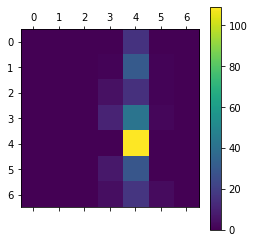

,0,1,2,3,4,5,6
0,0,0,0,0,16,0,0
1,0,0,0,1,31,1,0
2,0,0,0,5,15,1,0
3,0,0,0,11,42,2,0
4,0,0,0,0,109,0,0
5,0,0,0,7,29,0,0
6,0,0,0,4,17,3,0


In [37]:
MNB_Sift = MultinomialNB(alpha=1)

MNB_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_MNB = MNB_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_MNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_MNB))
print("Accuracy CrossValidation:", cross_val_score(MNB_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_MNB = confusion_matrix(y_test_Sift,y_pred_Sift_MNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_MNB)
DF_CM_SIFT_MNB = pd.DataFrame(data = CM_SIFT_MNB)
DF_CM_SIFT_MNB

#### **Gaussian Naive Bayes**

Modelo basado en una distribución continua y que se adecúa de mejor manera para tareas de clasificación más genéricas.

##### SURF

              precision    recall  f1-score   support

          CS       0.80      0.14      0.24        28
           D       0.12      0.21      0.15        48
          DH       0.05      0.02      0.03        58
          HE       0.22      0.14      0.17        94
          NI       0.59      0.80      0.68       240
          RL       0.18      0.08      0.11        79
          SH       0.16      0.24      0.19        41

    accuracy                           0.40       588
   macro avg       0.30      0.23      0.22       588
weighted avg       0.36      0.40      0.36       588

Accuracy Calculado: 0.39965986394557823
Accuracy CrossValidation: 0.40915211445402905 

MATRIZ DE CONFUSIÓN



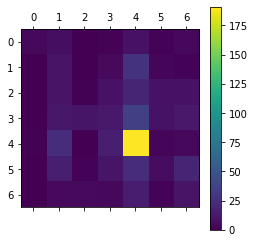

,0,1,2,3,4,5,6
0,4,7,0,2,9,2,4
1,0,10,0,5,28,3,2
2,0,10,1,9,20,9,9
3,0,12,11,13,36,9,13
4,1,25,0,16,191,3,4
5,0,16,2,11,24,6,20
6,0,5,5,4,15,2,10


In [38]:
GNB_Surf = GaussianNB()

GNB_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_GNB = GNB_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_GNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_GNB = confusion_matrix(y_test_Surf,y_pred_Surf_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_GNB)
DF_CM_SURF_GNB = pd.DataFrame(data = CM_SURF_GNB)
DF_CM_SURF_GNB

##### SIFT

              precision    recall  f1-score   support

          CS       0.25      0.38      0.30        16
           D       0.40      0.12      0.19        33
          DH       0.12      0.10      0.11        21
          HE       0.29      0.15      0.19        55
          NI       0.64      0.79      0.71       109
          RL       0.09      0.19      0.12        36
          SH       0.00      0.00      0.00        24

    accuracy                           0.38       294
   macro avg       0.26      0.25      0.23       294
weighted avg       0.37      0.38      0.36       294

Accuracy Calculado: 0.3843537414965986
Accuracy CrossValidation: 0.40368188512518416 

MATRIZ DE CONFUSIÓN



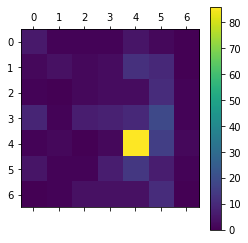

,0,1,2,3,4,5,6
0,6,1,1,1,5,2,0
1,2,4,2,3,12,10,0
2,1,0,2,3,3,11,1
3,9,1,7,8,10,19,1
4,1,2,0,2,86,16,2
5,5,1,1,7,14,7,1
6,0,1,4,4,4,11,0


In [39]:
GNB_Sift = GaussianNB()

GNB_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_GNB = GNB_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_GNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_GNB = confusion_matrix(y_test_Sift,y_pred_Sift_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_GNB)
DF_CM_SIFT_GNB = pd.DataFrame(data = CM_SIFT_GNB)
DF_CM_SIFT_GNB

#### **VotationClassifier**


              precision    recall  f1-score   support

          CS       0.20      0.19      0.19        16
           D       0.67      0.24      0.36        33
          DH       0.00      0.00      0.00        21
          HE       0.29      0.24      0.26        55
          NI       0.66      0.98      0.79       109
          RL       0.03      0.03      0.03        36
          SH       0.00      0.00      0.00        24

    accuracy                           0.45       294
   macro avg       0.26      0.24      0.23       294
weighted avg       0.39      0.45      0.39       294

Accuracy Calculado: 0.4489795918367347
Accuracy CrossValidation: 0.4628936110526685 

MATRIZ DE CONFUSIÓN



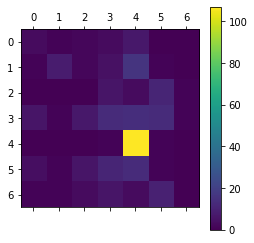

,0,1,2,3,4,5,6
0,3,1,2,3,7,0,0
1,1,8,2,5,16,1,0
2,0,0,0,6,3,11,1
3,6,1,7,13,14,13,1
4,0,0,0,1,107,1,0
5,4,1,6,11,13,1,0
6,1,1,3,6,3,10,0


In [40]:
estimadores = []
estimadores.append(("Naive Bayes", GaussianNB()))
estimadores.append(("Random Forest", RandomForestClassifier()))
estimadores.append(("SVM",svm.SVC()))

Voting = VotingClassifier(estimadores)

Voting.fit(X_train_Sift,y_train_Sift)

y_pred_Sift_Voting = Voting.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_Voting,zero_division=0))
print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_Voting))
print("Accuracy CrossValidation:", cross_val_score(Voting, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_VOTING = confusion_matrix(y_test_Sift, y_pred_Sift_Voting)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_VOTING)

DF_CM_SIFT_VOTING = pd.DataFrame(data = CM_SIFT_VOTING)
DF_CM_SIFT_VOTING



### Comparación de resultados

Para el análisis realizamos un gráfico de cajas que permitirá visualizar cada modelo.

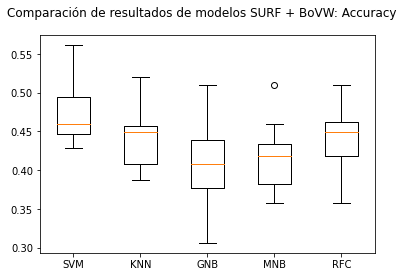

In [41]:
#@title Diagrama de Cajas - SURF
models = []

modelo = Sequential()


models.append(('SVM', SVM_Surf ))
models.append(('KNN', KNN_Surf))
models.append(('GNB', GNB_Surf))
models.append(('MNB', MNB_Surf))
models.append(('RFC', RF_Surf))

results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Surf, y_Surf, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos SURF + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

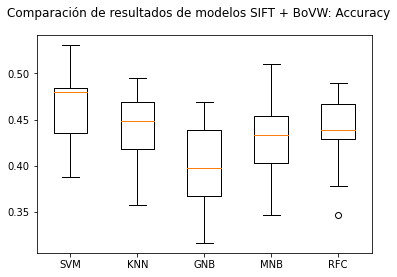

In [42]:
#@title Diagrama de Cajas - SIFT
models = []

modelo = Sequential()


models.append(('SVM', SVM_Sift))
models.append(('KNN', KNN_Sift))
models.append(('GNB', GNB_Sift))
models.append(('MNB', MNB_Sift))
models.append(('RFC', RF_Sift))

results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Sift, y_Sift, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos SIFT + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

En general, podemos darnos cuenta que el **accuracy** tanto en SIFT como en SURF no sobrepasan el 50% como media.

En el caso de SURF el mejor modelo respecto al accuracy es el Support Vector Machine con una media del 48%, superior a cualquier otro modelo.

Para SIFT, el modelo que obtuvo un mejor desempeño respecto al accuracy es el Random Forest, el cual obtiene un 46%.